In [1]:
import prepare_data
import eff_multi_task_unet
import numpy as np
import tensorflow as tf
import os
from utils import Prediction
from sklearn.model_selection import train_test_split

TF Version:  2.9.1


In [2]:
def training_data():
    y_train_1, y_train_2, y_train_3, std, inp_data = prepare_data.load_data()
    inp_data = np.swapaxes(inp_data,1,2)
    inp_data = np.swapaxes(inp_data,2,3)
    y_train_1 = np.squeeze(y_train_1,axis=1)
    inp_data = np.append(inp_data,std,axis=3)
    y_train_1,y_train_2,y_train_3 = y_train_1.astype('float64'),y_train_2.astype('float64'),y_train_3.astype('float64')
    return inp_data,y_train_1,y_train_2,y_train_3


def train_test_split_(x_train_inp,y_train_1,y_train_2,y_train_3):
    x_train, x_test, y_train, y_test = train_test_split(x_train_inp, y_train_1, test_size=0.20, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

    x_train_field, x_test_field, y_train_field, y_test_field = train_test_split(x_train_inp, y_train_2, test_size=0.20, random_state=42)
    x_train_field, x_val_field, y_train_field, y_val_field = train_test_split(x_train_field, y_train_field, test_size=0.20, random_state=0)

    x_train_field, x_test_field, y_train_extent, y_test_extent = train_test_split(x_train_inp, y_train_3, test_size=0.20, random_state=42)
    x_train_field, x_val_field, y_train_extent, y_val_extent = train_test_split(x_train_field, y_train_extent, test_size=0.20, random_state=0)
    return x_train,x_val,x_test,y_train,y_val,y_test,y_train_field,y_val_field,y_test_field,y_train_extent,y_val_extent,y_test_extent

inp_data,y_train_1,y_train_2,y_train_3 = training_data()
x_train,x_val,x_test,y_train,y_val,y_test,y_train_field,y_val_field,y_test_field,y_train_extent,y_val_extent,y_test_extent = train_test_split_(inp_data,y_train_1,y_train_2,y_train_3)
print(inp_data.shape,y_train_1.shape,y_train_2.shape,y_train_3.shape)

(1, 1520, 2223) (1520, 2223) (1520, 2223)
(133, 32, 256, 256) (133, 1, 256, 256) (133, 256, 256) (133, 256, 256) (133, 256, 256)
(133, 256, 256, 33) (133, 256, 256) (133, 256, 256) (133, 256, 256)


In [3]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

tf.random.set_seed(1234)
def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon))
metric = tf.keras.metrics.MeanIoU(num_classes=1)

def dice_coef(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def scheduler(epoch, lr):
    if epoch <8:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.03, mode='auto', patience=10,restore_best_weights=True)

input_shape = (256, 256, 33)
model = eff_multi_task_unet.build_effienet_unet(input_shape,Prediction.i)
Prediction.i+=1

def scheduler(epoch, lr):
    if epoch < 30:
        return 0.001
    elif epoch > 100 and epoch<150:
        return 0.00001
    else:
        return 0.0001
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

loss_list = {'segment_field': soft_dice_loss,'segment_extent':soft_dice_loss,'segment_boundary': soft_dice_loss}
test_metrics = {'segment_field': dice_coef, 'segment_extent':dice_coef,'segment_boundary': dice_coef}
loss_weights = {'segment_field': 0.33, 'segment_extent':0.33,'segment_boundary': 0.33}
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.03, mode='min', patience=6)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#              loss=loss_list,
#              metrics=test_metrics,
#              loss_weights = loss_weights
#              )
adam = tf.keras.optimizers.experimental.Adam(learning_rate=0.001)
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor
lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

# ...

optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr, weight_decay=wd)

sgd = tf.keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.99, nesterov=False, name="SGD")

model.compile(optimizer=adam, loss=loss_list, metrics=test_metrics,loss_weights=loss_weights)
#loss_weights=loss_weights)


KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 33), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 33), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [4]:
model_history=model.fit(x_train, [y_train,y_train_field,y_train_extent], epochs=10, batch_size = 4, 
                        validation_data=(x_val, [y_val,y_val_field,y_val_extent]))

Epoch 1/10
21/21 [==============================] - 46s 292ms/step - loss: 0.5717 - segment_boundary_loss: 0.6580 - segment_field_loss: 0.2823 - segment_extent_loss: 0.7922 - segment_boundary_dice_coef: 0.2123 - segment_field_dice_coef: 0.5247 - segment_extent_dice_coef: 0.1382 - val_loss: 0.5586 - val_segment_boundary_loss: 0.6260 - val_segment_field_loss: 0.2719 - val_segment_extent_loss: 0.7948 - val_segment_boundary_dice_coef: 0.2806 - val_segment_field_dice_coef: 0.5928 - val_segment_extent_dice_coef: 0.1514
Epoch 2/10
21/21 [==============================] - 3s 167ms/step - loss: 0.4932 - segment_boundary_loss: 0.5169 - segment_field_loss: 0.2143 - segment_extent_loss: 0.7634 - segment_boundary_dice_coef: 0.2834 - segment_field_dice_coef: 0.5846 - segment_extent_dice_coef: 0.1511 - val_loss: 0.5275 - val_segment_boundary_loss: 0.5738 - val_segment_field_loss: 0.2510 - val_segment_extent_loss: 0.7737 - val_segment_boundary_dice_coef: 0.2950 - val_segment_field_dice_coef: 0.5859 - 

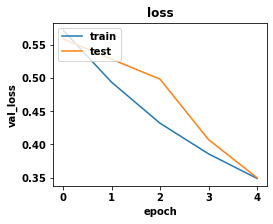

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 3))
plt.subplot(1,3,1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


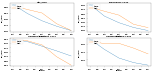

In [7]:
#with dropuout rate - 0.001, learning_rate = 0.00001, epochs = 80
p = Prediction(model=model)
#p.mIoU(x_test,y_test)
p.loss_plots(model_history)

In [8]:
from tensorflow.keras import backend as K
#model.save('my_model.h5')
model.save('my_model_3.h5')


In [9]:
model = tf.keras.models.load_model('my_model_3.h5',custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coef':dice_coef})


In [10]:
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 4s 4s/step
IoU socre is:  0.5104514135724831


(16, 256, 256)
1/1 [==============================] - 1s 760ms/step


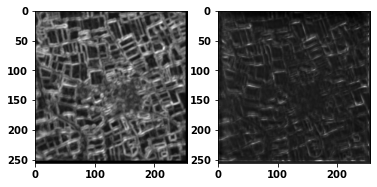

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


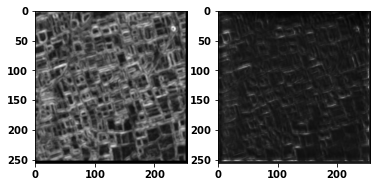

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


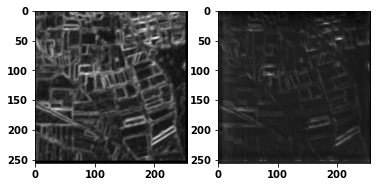

In [11]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

In [11]:
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 0s 96ms/step
IoU socre is:  0.5248011105771798


(16, 256, 256)
1/1 [==============================] - 1s 781ms/step


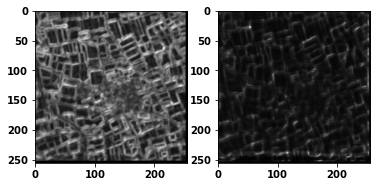

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


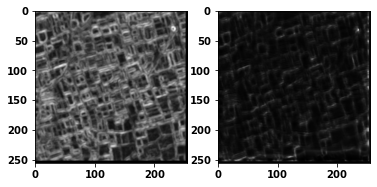

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


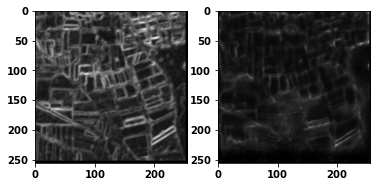

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

In [9]:
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 4s 4s/step
IoU socre is:  0.6476222704106297


(16, 256, 256)
1/1 [==============================] - 1s 796ms/step


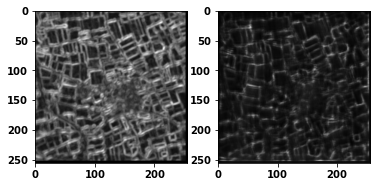

(16, 256, 256)
1/1 [==============================] - 0s 28ms/step


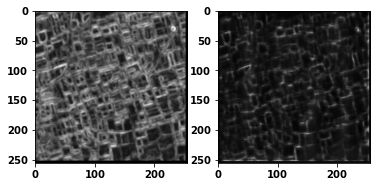

(16, 256, 256)
1/1 [==============================] - 0s 28ms/step


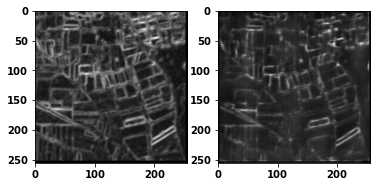

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

In [11]:
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 [==============================] - 4s 4s/step
IoU socre is:  0.6248194994117018


(16, 256, 256)
1/1 [==============================] - 1s 750ms/step


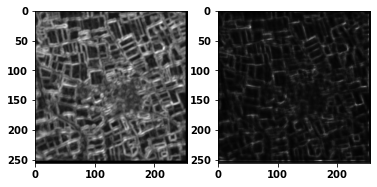

(16, 256, 256)
1/1 [==============================] - 0s 30ms/step


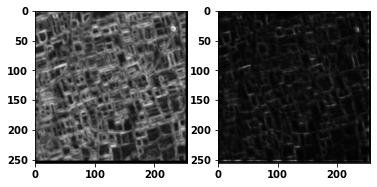

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


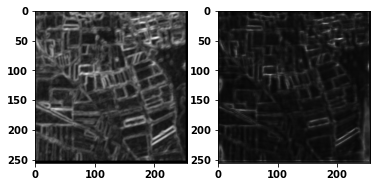

In [12]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 786ms/step


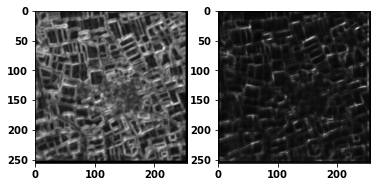

(16, 256, 256)
1/1 [==============================] - 0s 28ms/step


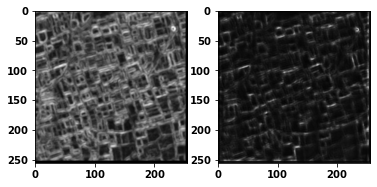

(16, 256, 256)
1/1 [==============================] - 0s 28ms/step


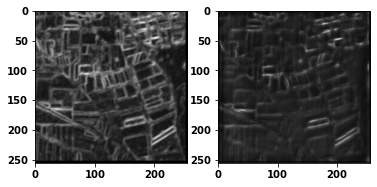

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 785ms/step


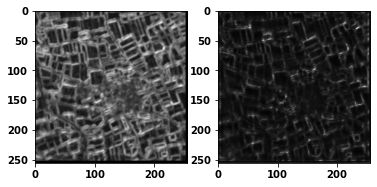

(16, 256, 256)
1/1 [==============================] - 0s 25ms/step


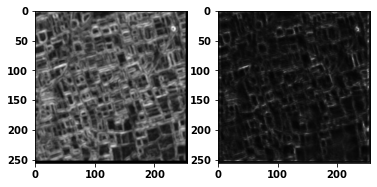

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


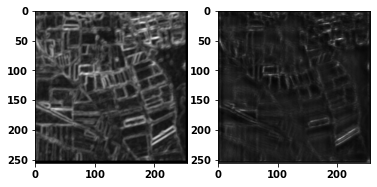

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 768ms/step


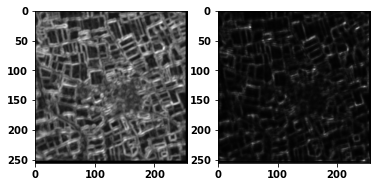

(16, 256, 256)
1/1 [==============================] - 0s 26ms/step


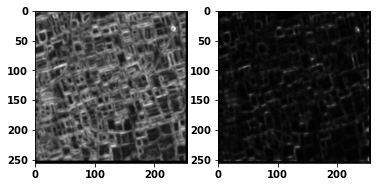

(16, 256, 256)
1/1 [==============================] - 0s 26ms/step


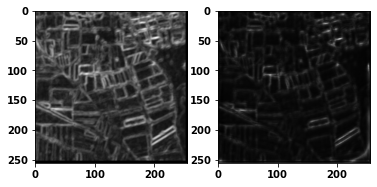

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 985ms/step


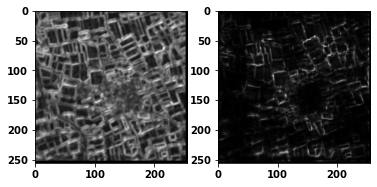

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


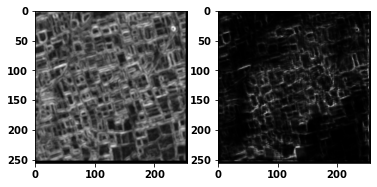

(16, 256, 256)
1/1 [==============================] - 0s 25ms/step


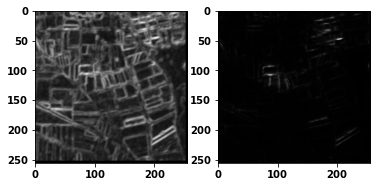

In [12]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 771ms/step


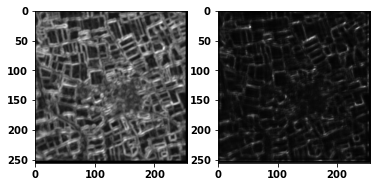

(16, 256, 256)
1/1 [==============================] - 0s 26ms/step


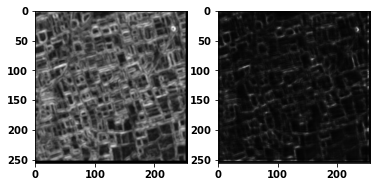

(16, 256, 256)
1/1 [==============================] - 0s 26ms/step


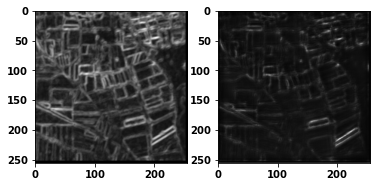

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 781ms/step


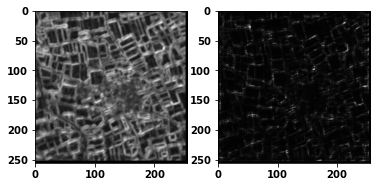

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


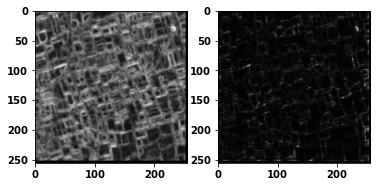

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


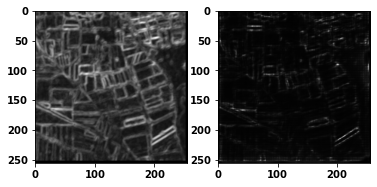

In [10]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)
1/1 [==============================] - 1s 799ms/step


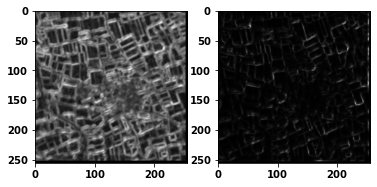

(16, 256, 256)
1/1 [==============================] - 0s 26ms/step


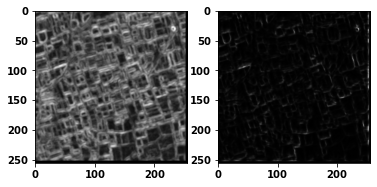

(16, 256, 256)
1/1 [==============================] - 0s 27ms/step


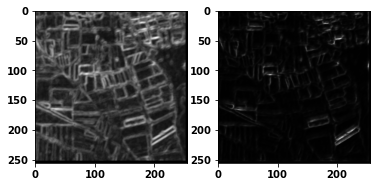

In [11]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)


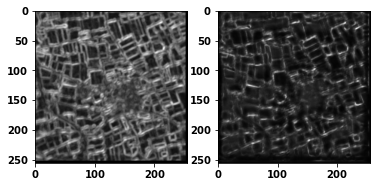

(16, 256, 256)


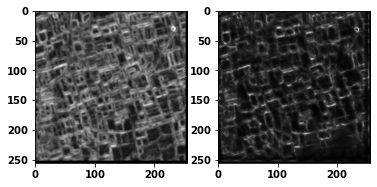

(16, 256, 256)


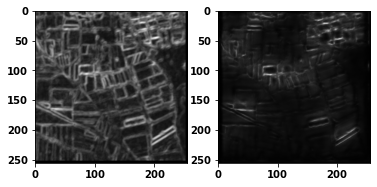

In [16]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

In [11]:
#with lr-0.01, epochs-30, No Ealry Stopping, dropout - 0.001
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6472493282421157


(16, 256, 256)


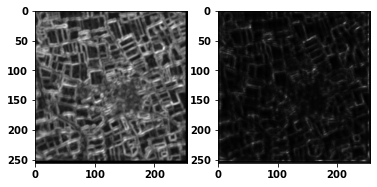

(16, 256, 256)


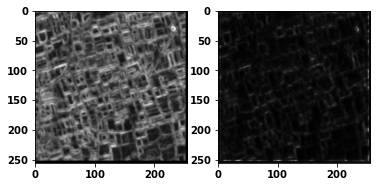

(16, 256, 256)


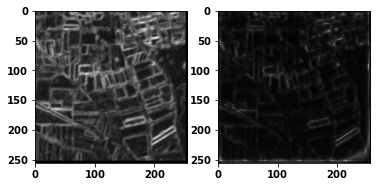

In [12]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
inp = []
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

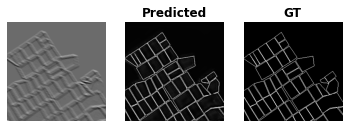

In [19]:
import random
import matplotlib.pyplot as plt

image_number = random.randint(0, len(x_test)-1)

y_pred = np.array(y_pred)
pred_mask_img_test = y_pred

plt.subplot(1,3,1)
plt.imshow(x_test[image_number,:,:,10],cmap='gray')
plt.title("")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(pred_mask_img_test[image_number,:,:,0],cmap='gray')
plt.title("Predicted")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(y_test[image_number,:,:],cmap='gray')
plt.title("GT")
plt.axis("off")
plt.show()

(16, 256, 256)


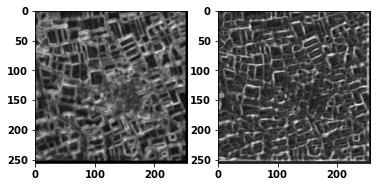

(16, 256, 256)


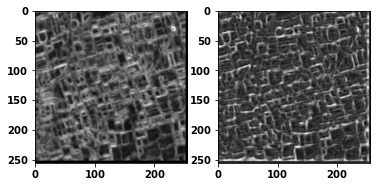

(16, 256, 256)


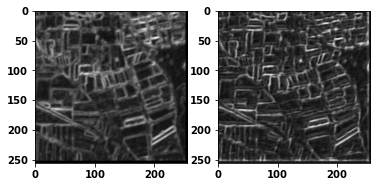

In [8]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)


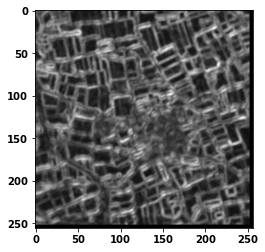

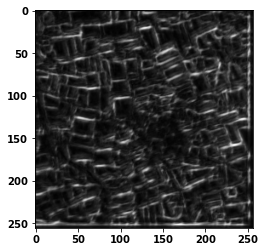

(16, 256, 256)


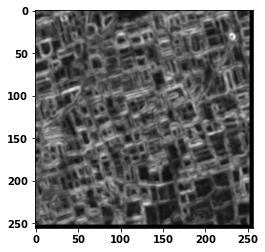

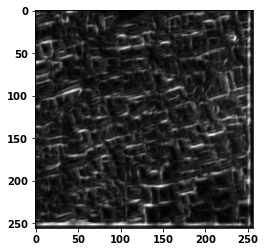

(16, 256, 256)


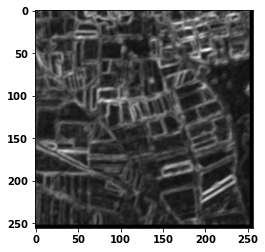

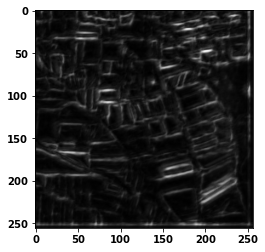

In [6]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

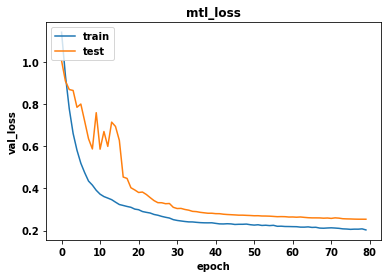

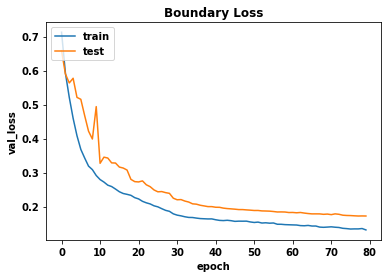

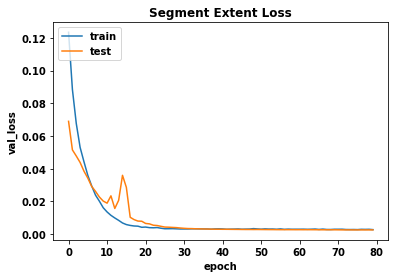

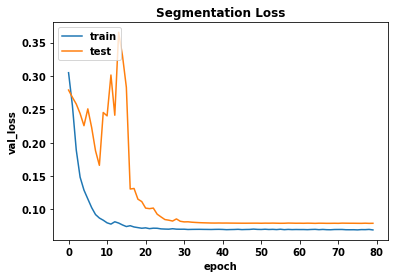

In [5]:
#with dropuout rate - 0.001, 1
p = Prediction(model=model)
#p.mIoU(x_test,y_test)
p.loss_plots(model_history)

(16, 256, 256)


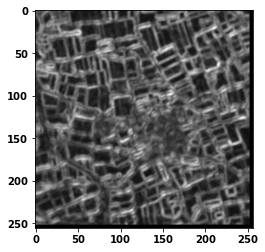

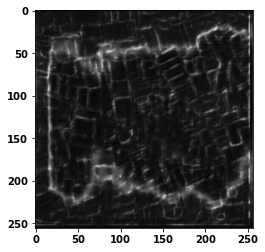

(16, 256, 256)


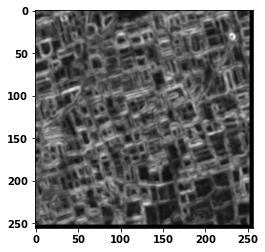

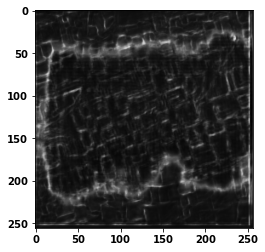

(16, 256, 256)


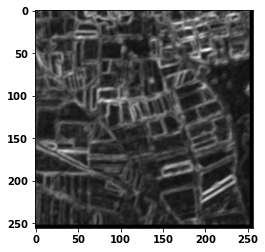

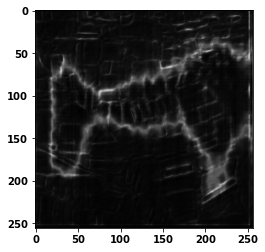

In [9]:
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)


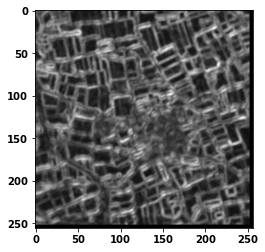

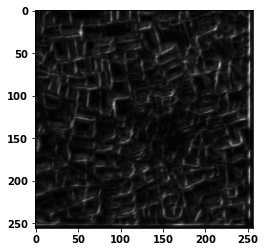

(16, 256, 256)


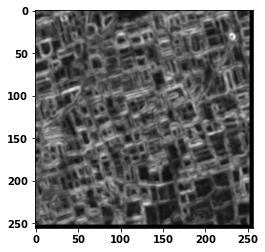

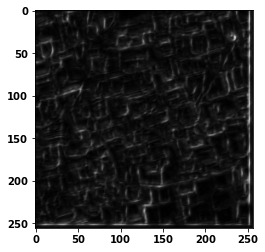

(16, 256, 256)


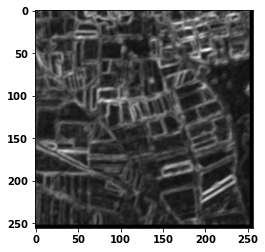

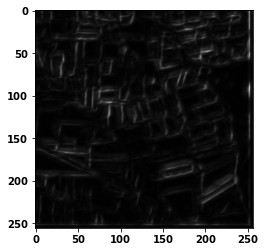

In [15]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

(16, 256, 256)


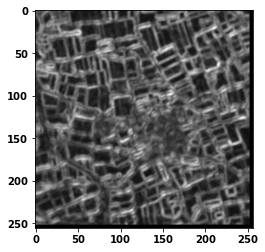

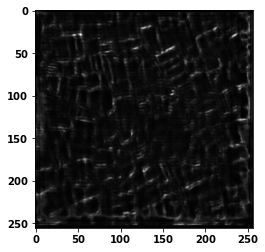

(16, 256, 256)


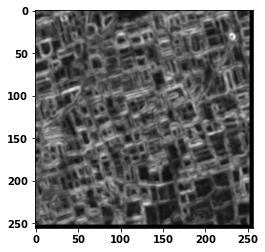

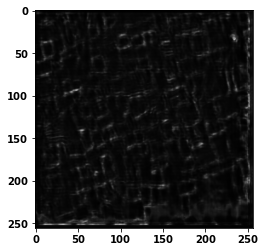

(16, 256, 256)


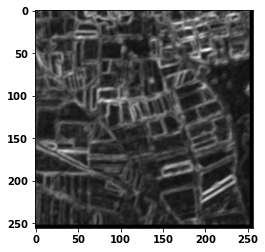

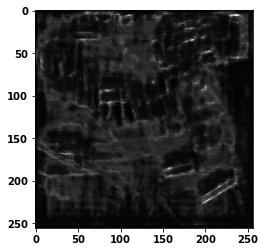

In [6]:
data_file_ = ['clipped_small_parcels.tif', 'clipped_small_parcels_3.tif','clipped_small_parcels_4.tif']
for file in data_file_: 
    p = Prediction(data_file=file,model=model)
    p.pred_data()

In [8]:
model.load_weights(checkpoint_path)

In [9]:
from tensorflow.keras import backend as K
y_pred=model.predict(x_test)
pred_mask_img_test = y_pred[0]
y_pred = pred_mask_img_test

y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = y_pred_thresholded[:,:,:,0]

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6496738292240679
